In [20]:
import sys
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [21]:
pip install neurokit2

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import neurokit2 as nk

In [34]:
file_path = "/content/drive/MyDrive/bsp final project/ECG measures data/Subject_02/2_Post_Isometric/ecg.dat"
raw_data = np.frombuffer(open(file_path, 'rb').read(), dtype=np.int16)

ecg_clean = nk.ecg_clean(raw_data, sampling_rate=fs, method="neurokit")
_, info = nk.ecg_peaks(ecg_clean, sampling_rate=250, method="neurokit")
r_peaks = info["ECG_R_Peaks"]

--- Procesando: ecg.dat ---
-> Archivo cargado como BINARIO (int16).
Picos detectados inicialmente: 52
Intervalos eliminados (ruido): 0

     RMSSD CORREGIDO: 13.01 ms



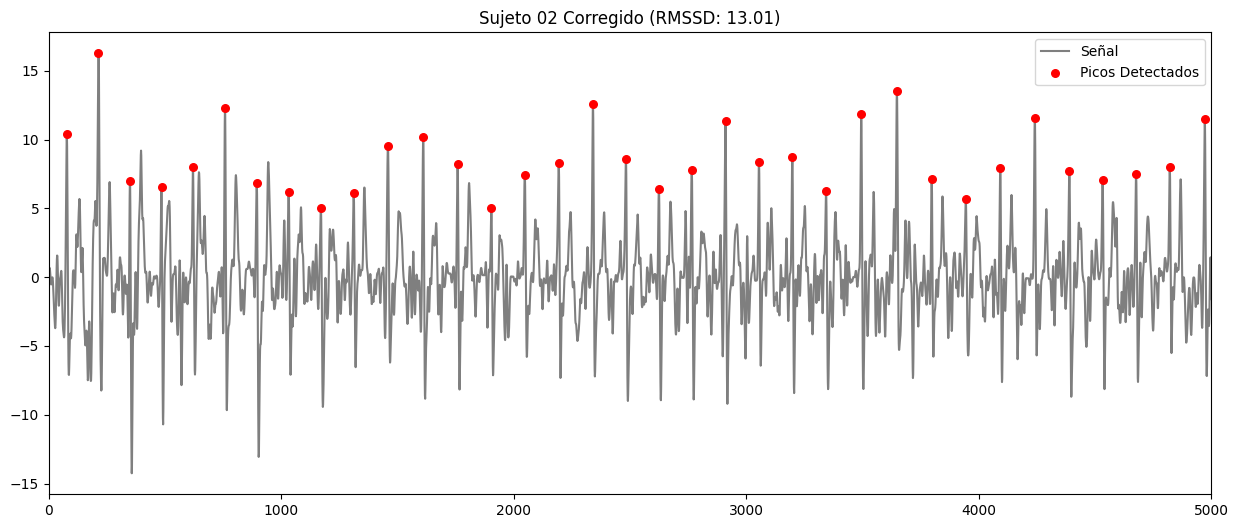

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import neurokit2 as nk
import os

# ----------------------------------------
# CONFIGURACIÓN
# ----------------------------------------
file_path = "/content/drive/MyDrive/bsp final project/ECG measures data/Subject_02/2_Post_Isometric/ecg.dat"
fs = 250

print(f"--- Procesando: {os.path.basename(file_path)} ---")

# ----------------------------------------
# 1. LECTURA DEL ECG
# ----------------------------------------
try:
    # Intento Texto
    raw_data = np.loadtxt(file_path)
    if raw_data.ndim > 1: raw_data = raw_data[:, -1]
    print("-> Archivo cargado como TEXTO.")
except:
    # Intento Binario
    try:
        raw_data = np.frombuffer(open(file_path, 'rb').read(), dtype=np.int16)
        print("-> Archivo cargado como BINARIO (int16).")
    except Exception as e:
        print(f"ERROR: {e}")
        raw_data = np.array([])

if len(raw_data) > 0:
    # ----------------------------------------
    # 2. LIMPIEZA BÁSICA
    # ----------------------------------------
    ecg_clean = nk.ecg_clean(raw_data, sampling_rate=fs, method="neurokit")

    # ----------------------------------------
    # 3. DETECCIÓN DE PICOS (Sin fixpeaks problemático)
    # ----------------------------------------
    _, info = nk.ecg_peaks(ecg_clean, sampling_rate=fs)
    r_peaks = info["ECG_R_Peaks"]

    # Asegurarnos de que son enteros y están ordenados
    r_peaks = np.sort(r_peaks.astype(int))
    print(f"Picos detectados inicialmente: {len(r_peaks)}")

    # ----------------------------------------
    # 4. FILTRADO DE ARTEFACTOS (MATEMÁTICO)
    # ----------------------------------------
    # Aquí es donde arreglamos el RMSSD alto sin usar librerías raras.

    # a) Calcular intervalos en milisegundos
    rr_intervals = np.diff(r_peaks) / fs * 1000

    # b) Identificar intervalos IMPOSIBLES (Ruido)
    # Menos de 300ms = 200 bpm (imposible en reposo/recuperación)
    # Más de 2000ms = 30 bpm (o pérdida de señal)
    valid_mask = (rr_intervals > 300) & (rr_intervals < 2000)

    clean_rr = rr_intervals[valid_mask]
    n_removed = len(rr_intervals) - len(clean_rr)

    print(f"Intervalos eliminados (ruido): {n_removed}")

    # ----------------------------------------
    # 5. CÁLCULO DE RMSSD FINAL
    # ----------------------------------------
    diff_rr = np.diff(clean_rr)
    rmssd = np.sqrt(np.mean(diff_rr**2))

    print("\n==============================")
    print(f"     RMSSD CORREGIDO: {rmssd:.2f} ms")
    print("==============================\n")

    # ----------------------------------------
    # 6. VISUALIZACIÓN DEL PROBLEMA
    # ----------------------------------------
    plt.figure(figsize=(15, 6))

    # Señal
    plt.plot(ecg_clean, color='black', alpha=0.5, label='Señal')
    # Picos marcados
    plt.scatter(r_peaks, ecg_clean[r_peaks], color='red', s=30, label='Picos Detectados', zorder=5)

    plt.title(f"Sujeto 02 Corregido (RMSSD: {rmssd:.2f})")
    plt.legend()
    plt.xlim(0, 5000) # Ver primeros segundos
    plt.show()

else:
    print("No hay datos.")

In [35]:
rr_intervals = np.diff(r_peaks) / 250 * 1000
valid_mask = (rr_intervals > 300) & (rr_intervals < 2000)

clean_rr = rr_intervals[valid_mask]
n_removed = len(rr_intervals) - len(clean_rr)

diff_rr = np.diff(clean_rr)
mssd = np.sqrt(np.mean(diff_rr**2))

In [40]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import os

# ==========================================
# 1. FUNCIONES AUXILIARES
# ==========================================

def detect_sampling_rate(filename):
    """Detecta si es 1000Hz o 250Hz por el nombre."""
    if "ecg1k" in filename or "1000" in filename:
        return 1000
    return 250

def preprocess_ecg(file_path):
    """
    Carga y limpia la señal de forma robusta.
    """
    try:
        filename = os.path.basename(file_path)
        sampling_rate = detect_sampling_rate(filename)

        # --- CARGA INTELIGENTE ---
        try:
            raw_data = np.loadtxt(file_path)
            if raw_data.ndim > 1: raw_data = raw_data[:, -1]
        except:
            with open(file_path, 'rb') as f:
                raw_data = np.frombuffer(f.read(), dtype=np.int16)

        if len(raw_data) == 0: return None, sampling_rate

        # --- LIMPIEZA NEUROKIT ---
        ecg_cleaned = nk.ecg_clean(raw_data, sampling_rate=sampling_rate, method="neurokit")

        # --- DETECCIÓN DE PICOS ---
        # Usamos método básico para evitar errores de tipo
        _, info = nk.ecg_peaks(ecg_cleaned, sampling_rate=sampling_rate)
        r_peaks = info["ECG_R_Peaks"]

        # Ordenar y asegurar formato
        r_peaks = np.sort(r_peaks.astype(int))

        return r_peaks, sampling_rate

    except Exception as e:
        print(f"   [ERROR] en {os.path.basename(file_path)}: {e}")
        return None, 250

# ==========================================
# 2. CÁLCULO DE RMSSD (EL FILTRO ESTRICTO)
# ==========================================

def calculate_rmssd_strict(r_peaks, fs=250):
    """
    Calcula RMSSD aplicando los filtros que arreglaron al Sujeto 2,
    pero aplicados a TODOS.
    """
    if len(r_peaks) < 2:
        return None

    # 1. Convertir a intervalos en milisegundos
    rr_intervals = np.diff(r_peaks) / fs * 1000

    # --- FILTRO 1: FISIOLÓGICO ESTRICTO ---
    # Menos de 300ms (Taquicardia irreal/Ruido)
    # Más de 1300ms (Bradicardia extrema o Latido perdido)
    # NOTA: 1300ms = 46 bpm. Si son atletas durmiendo podría ser bajo,
    # pero para estudiantes despiertos, >1300 suele ser error de detección.
    valid_rr = rr_intervals[(rr_intervals > 300) & (rr_intervals < 1300)]

    if len(valid_rr) < 2:
        return None

    # --- FILTRO 2: ESTADÍSTICO (OUTLIER REMOVAL) ---
    # Esto ayuda a limpiar a los otros sujetos (como el 5 y el 6).
    # Eliminamos cualquier latido que se aleje un 30% de la media local.
    mean_rr = np.mean(valid_rr)
    upper_limit = mean_rr * 1.30
    lower_limit = mean_rr * 0.70

    clean_rr = valid_rr[(valid_rr > lower_limit) & (valid_rr < upper_limit)]

    if len(clean_rr) < 2:
        return None

    # 3. Calcular RMSSD final
    diff_rr = np.diff(clean_rr)
    rmssd = np.sqrt(np.mean(diff_rr**2))

    return rmssd

# ==========================================
# 3. PROCESAMIENTO MASIVO (LOOP)
# ==========================================

DATASET_PATH = "/content/drive/MyDrive/bsp final project/ECG measures data"

STAGES_MAP = {
    '1_Baseline': 'Baseline',
    '2_Post_Isometric': 'Post_Iso',
    '3_Recovery_Isometric': 'Rec_Iso',
    '4_Post_Isotonic': 'Post_Ton',
    '5_Recovery_Isotonic': 'Rec_Ton'
}

results = []

if os.path.exists(DATASET_PATH):
    subjects = sorted([d for d in os.listdir(DATASET_PATH) if d.startswith('Subject')])
    print(f"Aplicando filtro estricto a {len(subjects)} sujetos...")
    print("-" * 60)

    for subject in subjects:
        row = {'Subject': subject}
        # print(f"Procesando {subject}...") # Descomentar si quieres ver el progreso

        for folder_name, logic_name in STAGES_MAP.items():

            # Buscar archivo
            path_base = os.path.join(DATASET_PATH, subject, folder_name)
            path_1k = os.path.join(path_base, 'ecg1k.dat')
            path_std = os.path.join(path_base, 'ecg.dat')

            final_path = path_1k if os.path.exists(path_1k) else path_std

            rmssd_val = None

            if os.path.exists(final_path):
                # 1. Preprocesar (Obtener picos)
                r_peaks, fs = preprocess_ecg(final_path)

                # 2. Calcular RMSSD con la nueva función ESTRICTA
                if r_peaks is not None:
                    rmssd_val = calculate_rmssd_strict(r_peaks, fs)

            row[f"{logic_name}_RMSSD"] = rmssd_val

        # Calcular Deltas
        if row.get('Rec_Iso_RMSSD') and row.get('Post_Iso_RMSSD'):
            row['Delta_Isometric'] = row['Rec_Iso_RMSSD'] - row['Post_Iso_RMSSD']
        else:
            row['Delta_Isometric'] = None

        if row.get('Rec_Ton_RMSSD') and row.get('Post_Ton_RMSSD'):
            row['Delta_Isotonic'] = row['Rec_Ton_RMSSD'] - row['Post_Ton_RMSSD']
        else:
            row['Delta_Isotonic'] = None

        results.append(row)

    # ==========================================
    # 4. MOSTRAR RESULTADOS
    # ==========================================
    df = pd.DataFrame(results)

    desired_cols = ['Subject', 'Baseline_RMSSD',
                    'Post_Iso_RMSSD', 'Rec_Iso_RMSSD', 'Delta_Isometric',
                    'Post_Ton_RMSSD', 'Rec_Ton_RMSSD', 'Delta_Isotonic']

    final_cols = [c for c in desired_cols if c in df.columns]

    print("\n=== HRV ANALYSIS RESULTS (FILTRO ESTRICTO APLICADO) ===")
    print(df[final_cols].round(2).to_markdown(index=False))

else:
    print(f"Ruta no encontrada: {DATASET_PATH}")

Aplicando filtro estricto a 6 sujetos...
------------------------------------------------------------

=== HRV ANALYSIS RESULTS (FILTRO ESTRICTO APLICADO) ===
| Subject    |   Baseline_RMSSD |   Post_Iso_RMSSD |   Rec_Iso_RMSSD |   Delta_Isometric |   Post_Ton_RMSSD |   Rec_Ton_RMSSD |   Delta_Isotonic |
|:-----------|-----------------:|-----------------:|----------------:|------------------:|-----------------:|----------------:|-----------------:|
| Subject_01 |           105.51 |            60.35 |           47.26 |            -13.08 |           102.65 |           99.39 |            -3.26 |
| Subject_02 |            39.69 |            13.01 |           37.23 |             24.22 |            40.08 |           14.09 |           -25.99 |
| Subject_03 |            65.36 |            33.1  |           32.48 |             -0.62 |            11.94 |           33.07 |            21.13 |
| Subject_04 |            16.35 |             9.2  |           19.21 |             10.01 |             6.6